# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [3]:
print_errors = False
build_new_dataset = False
symbol_list = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [4]:
if symbol_list == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbol_list == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [5]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [6]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2024-12-31,NaN,NaN,NaN,Basic Materials,Aluminum,246000000.0,-2.166667e+08,-3.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-440000000.0,0.000000e+00,-7.200000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243343,Basic Materials,Aluminum,342000000.0,-5.000000e+08,-1.000000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,530000000.0,-1.500000e+08,-1.294000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574373,Basic Materials,Aluminum,169500000.0,-2.166667e+08,-4.402500e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,ZUMZ,2025-01-31,NaN,NaN,NaN,Consumer Cyclical,Apparel Retail,49699000.0,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5201,ZUMZ,2024-01-31,-0.002912,0.480489,-0.089691,Consumer Cyclical,Apparel Retail,-5595000.0,0.000000e+00,-4.944000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5202,ZUMZ,2023-01-31,-0.363531,-0.272938,-0.313202,Consumer Cyclical,Apparel Retail,-26006000.0,-8.786000e+07,-2.268800e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5203,ZUMZ,2022-01-31,-0.155506,-0.400445,-0.428254,Consumer Cyclical,Apparel Retail,119201000.0,-1.937890e+08,-2.480000e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Get columns with less than 2000 datapoints
columns_to_remove = [col for col in df.columns if df[col].notna().sum() < 3500]
# Remove these columns from the dataframe
df = df.drop(columns=columns_to_remove)
print(columns_to_remove)
df

['Effect Of Exchange Rate Changes', 'Proceeds From Stock Option Exercised', 'Preferred Stock Dividend Paid', 'Purchase Of Investment', 'Capital Expenditure Reported', 'Change In Other Current Liabilities', 'Change In Other Current Assets', 'Change In Accrued Expense', 'Change In Tax Payable', 'Change In Income Tax Payable', 'Change In Prepaid Assets', 'Change In Inventory', 'Depreciation', 'Pension And Employee Benefit Expense', 'Earnings Losses From Equity Investments', 'Gain Loss On Investment Securities', 'Minority Interest', 'Preferred Stock', 'Derivative Product Liabilities', 'Employee Benefits', 'Non Current Pension And Other Postretirement Benefit Plans', 'Tradeand Other Payables Non Current', 'Non Current Deferred Revenue', 'Long Term Provisions', 'Other Current Liabilities', 'Other Current Borrowings', 'Pensionand Other Post Retirement Benefit Plans Current', 'Total Tax Payable', 'Defined Pension Benefit', 'Non Current Prepaid Assets', 'Non Current Deferred Assets', 'Non Curre

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Interest Income,Total Operating Income As Reported,General And Administrative Expense,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale,Purchase Of PPE,Current Accrued Expenses,Asset Impairment Charge,Treasury Shares Number
0,AA,2024-12-31,NaN,NaN,NaN,Basic Materials,Aluminum,246000000.0,-2.166667e+08,-3.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-440000000.0,0.000000e+00,-7.200000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243343,Basic Materials,Aluminum,342000000.0,-5.000000e+08,-1.000000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,530000000.0,-1.500000e+08,-1.294000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574373,Basic Materials,Aluminum,169500000.0,-2.166667e+08,-4.402500e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,ZUMZ,2025-01-31,NaN,NaN,NaN,Consumer Cyclical,Apparel Retail,49699000.0,0.000000e+00,0.000000e+00,...,742000.0,20130000.0,NaN,NaN,NaN,-4992000.0,-4992000.0,21962000.0,938000.0,0.0
5201,ZUMZ,2024-01-31,-0.002912,0.480489,-0.089691,Consumer Cyclical,Apparel Retail,-5595000.0,0.000000e+00,-4.944000e+07,...,3522000.0,-64789000.0,NaN,NaN,NaN,-20350000.0,-20350000.0,18431000.0,43904000.0,0.0
5202,ZUMZ,2023-01-31,-0.363531,-0.272938,-0.313202,Consumer Cyclical,Apparel Retail,-26006000.0,-8.786000e+07,-2.268800e+07,...,1924000.0,31100000.0,NaN,NaN,NaN,-25627000.0,-25627000.0,16321000.0,2081000.0,0.0
5203,ZUMZ,2022-01-31,-0.155506,-0.400445,-0.428254,Consumer Cyclical,Apparel Retail,119201000.0,-1.937890e+08,-2.480000e+05,...,3592000.0,157810000.0,NaN,NaN,NaN,-15749000.0,-15749000.0,38616000.0,2229000.0,0.0


### Impution and encoding

In [8]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [9]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Interest Income,Total Operating Income As Reported,General And Administrative Expense,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale,Purchase Of PPE,Current Accrued Expenses,Asset Impairment Charge,Treasury Shares Number
0,0,2024-12-31,NaN,NaN,NaN,0,5,-0.018444,6.214759e-02,0.060828,...,0.000000,0.000000,-1.147410e-17,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
5,1,2024-12-31,NaN,NaN,NaN,8,94,-0.018652,-1.058148e-17,0.060914,...,-0.072749,-0.042055,-9.492661e-02,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
10,2,2025-01-31,NaN,NaN,NaN,7,120,-0.018785,7.081834e-02,0.060833,...,0.000000,-0.042019,-1.147410e-17,2.156704e-02,0.065622,0.066301,0.078787,-0.078971,-6.322465e-02,-1.614161e-17
15,3,2024-12-31,NaN,NaN,NaN,8,98,-0.018628,7.176368e-02,0.060018,...,-0.072435,0.000000,-9.487027e-02,5.001454e-18,0.000000,0.000000,0.000000,0.000000,-6.483512e-02,-1.039967e-01
20,4,2024-12-31,NaN,NaN,NaN,6,74,-0.016683,5.778337e-02,0.060755,...,-0.072645,-0.040638,-1.147410e-17,2.789389e-02,0.074866,0.065579,0.078078,-0.067302,8.953199e-18,1.774030e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,1036,2024-12-31,NaN,NaN,NaN,6,76,-0.018638,7.176368e-02,0.060920,...,-0.072755,-0.042461,-9.255013e-02,2.644643e-02,0.064706,0.066320,0.000000,-0.078774,-4.600592e-02,-3.282744e-02
5185,1037,2024-12-31,NaN,NaN,NaN,11,139,-0.018677,-1.058148e-17,0.060941,...,0.000000,-0.042072,-9.493482e-02,5.001454e-18,0.000000,0.066302,0.078788,-0.079727,8.953199e-18,-1.614161e-17
5190,1038,2024-12-31,NaN,NaN,NaN,1,66,-0.018597,7.176368e-02,0.060797,...,0.000000,-0.042129,-9.473234e-02,2.774704e-02,0.074651,0.066283,0.078769,-0.079589,-6.493234e-02,-1.039967e-01
5195,1039,2024-12-31,NaN,NaN,NaN,9,24,-0.018405,7.038784e-02,0.060943,...,-0.072728,-0.041908,-9.477896e-02,1.857283e-02,0.061248,0.066299,0.078785,-0.079260,8.953199e-18,-8.163220e-02


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Interest Income,Total Operating Income As Reported,General And Administrative Expense,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale,Purchase Of PPE,Current Accrued Expenses,Asset Impairment Charge,Treasury Shares Number
1,0,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.019079,7.176368e-02,0.060922,...,0.000000,0.000000,-1.147410e-17,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
2,0,2022-12-31,-0.062309,-0.250328,-0.243343,0,5,-0.018355,4.957271e-02,0.060943,...,0.000000,0.000000,-1.147410e-17,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
3,0,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.018181,6.510639e-02,0.060563,...,0.000000,0.000000,-1.147410e-17,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
4,0,2020-12-31,0.398265,0.603471,1.574373,0,5,-0.018515,6.214759e-02,0.060814,...,0.000000,0.000000,-1.147410e-17,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
6,1,2023-12-31,-0.031142,-0.031311,0.220023,8,94,-0.018574,-1.058148e-17,0.060889,...,-0.072753,-0.041986,-9.488580e-02,5.001454e-18,0.000000,0.000000,0.000000,0.000000,8.953199e-18,-1.614161e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,1039,2020-12-31,0.279577,0.384279,0.554758,9,24,-0.018297,6.187760e-02,0.060885,...,-0.072728,-0.041660,-9.450223e-02,1.857283e-02,0.061248,0.066256,0.078743,-0.078976,8.953199e-18,-8.210001e-02
5201,1040,2024-01-31,-0.002912,0.480489,-0.089691,2,7,-0.018677,7.176368e-02,0.060929,...,-0.072751,-0.042126,-1.147410e-17,5.001454e-18,0.000000,0.066297,0.078783,-0.079696,-6.328364e-02,-1.039967e-01
5202,1040,2023-01-31,-0.363531,-0.272938,-0.313202,2,7,-0.018696,6.786428e-02,0.060937,...,-0.072753,-0.042054,-1.147410e-17,5.001454e-18,0.000000,0.066291,0.078778,-0.079700,-6.485420e-02,-1.039967e-01
5203,1040,2022-01-31,-0.155506,-0.400445,-0.428254,2,7,-0.018561,6.316295e-02,0.060943,...,-0.072751,-0.041959,-1.147410e-17,5.001454e-18,0.000000,0.066302,0.078788,-0.079656,-6.484864e-02,-1.039967e-01


### Labeling

In [10]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Interest Income,Total Operating Income As Reported,General And Administrative Expense,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale,Purchase Of PPE,Current Accrued Expenses,Asset Impairment Charge,Treasury Shares Number
838,242,11,137,-0.019033,-1.058148e-17,6.087431e-02,-0.062195,5.732672e-02,-0.078969,-0.078509,...,-0.072752,-0.041214,-1.147410e-17,4.673179e-02,0.074866,0.066181,0.078670,-0.079495,-6.410619e-02,-1.614161e-17
4392,650,6,16,-0.018755,7.172533e-02,6.090982e-02,-0.062270,5.938161e-02,-0.079252,-0.078593,...,-0.072754,-0.042153,-1.147410e-17,2.789389e-02,0.000000,0.066316,0.078802,-0.079726,-6.493234e-02,-1.034680e-01
2803,908,8,97,-0.018509,6.843503e-02,5.988490e-02,-0.061198,5.923356e-02,-0.079267,-0.078624,...,-0.072756,0.000000,-9.486674e-02,2.789445e-02,0.000000,0.066312,0.078798,0.000000,-6.493234e-02,-1.039967e-01
3226,30,6,16,-0.018963,7.176368e-02,6.094334e-02,0.000000,5.936562e-02,-0.079224,-0.078541,...,-0.072715,-0.042372,-1.147410e-17,2.789389e-02,0.000000,0.066318,0.078803,-0.079693,8.953199e-18,-8.643031e-02
4844,871,5,31,-0.018714,4.245814e-02,6.064553e-02,-0.061989,-7.101384e-18,-0.076243,-0.075406,...,-0.070602,0.000000,-9.454924e-02,2.714757e-02,0.073776,0.000000,0.000000,0.000000,-6.354022e-02,1.114757e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,266,2,50,-0.018669,-1.058148e-17,6.094334e-02,-0.062282,5.937805e-02,-0.079271,-0.078628,...,-0.072755,-0.042070,-9.490723e-02,2.789389e-02,0.074866,0.066315,0.078798,-0.079724,8.953199e-18,-1.614161e-17
3496,150,6,36,-0.018762,-1.058148e-17,6.087237e-02,-0.062204,5.938082e-02,-0.079208,-0.078425,...,-0.072737,-0.042156,-1.147410e-17,5.001454e-18,0.000000,0.066315,0.078801,-0.079690,-6.487421e-02,-1.039967e-01
3084,990,2,109,-0.017999,5.505013e-02,5.998467e-02,-0.061534,5.932958e-02,-0.078447,-0.077621,...,-0.072739,-0.041235,-1.147410e-17,2.615069e-02,0.068860,0.066259,0.078746,-0.077884,-6.344604e-02,-9.093083e-02
1876,588,4,83,-0.018552,-1.058148e-17,6.084064e-02,-0.062217,5.938025e-02,-0.079240,-0.078605,...,-0.072752,-0.042058,-9.493064e-02,2.789389e-02,0.074866,0.066315,0.078801,-0.079703,-6.306790e-02,-1.614161e-17


,3M Future Change,6M Future Change,1Y Future Change
838,0.100817,0.075958,0.001784
4392,0.272251,0.198953,-0.198953
2803,-0.111654,-0.331388,-0.296484
3226,0.283019,0.913559,0.508117
4844,0.477387,0.699878,0.589102
...,...,...,...
3584,0.146199,0.223893,0.472849
3496,-0.165846,0.003284,0.267652
3084,0.211756,0.491099,0.439423
1876,-0.092077,0.466194,-0.035780


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Interest Income,Total Operating Income As Reported,General And Administrative Expense,Net Business Purchase And Sale,Purchase Of Business,Net PPE Purchase And Sale,Purchase Of PPE,Current Accrued Expenses,Asset Impairment Charge,Treasury Shares Number
4812,846,9,115,-0.018676,-1.058148e-17,0.060926,-0.062267,5.938208e-02,-0.079270,-0.078624,...,-0.072756,-0.042080,-1.147410e-17,2.789389e-02,0.000000,0.000000,0.000000,-0.079732,-6.492393e-02,-1.039967e-01
4059,471,6,35,-0.018633,6.985286e-02,0.060914,-0.062255,5.911267e-02,-0.078504,-0.077864,...,-0.072712,-0.041601,-9.382722e-02,8.709236e-03,0.053597,0.066068,0.078550,0.000000,-6.199054e-02,-9.485201e-02
1151,351,8,102,-0.017158,7.176368e-02,0.059943,-0.061297,-7.101384e-18,-0.078207,-0.078533,...,-0.072731,-0.041682,-9.426453e-02,2.481502e-02,0.062951,0.000000,0.000000,0.000000,-6.048752e-02,-1.039967e-01
534,170,5,13,0.297090,7.176368e-02,0.055538,-0.062278,4.932223e-02,0.430208,0.331689,...,0.492484,0.000000,7.037199e-02,-2.046720e-01,-0.264921,0.055222,0.067919,0.000000,8.953199e-18,-1.614161e-17
1266,383,2,7,-0.018811,7.131986e-02,0.060899,-0.062245,5.915759e-02,-0.079063,-0.078233,...,-0.072750,-0.041970,-9.215459e-02,2.818757e-02,0.074805,0.066324,0.000000,-0.079304,-6.343025e-02,-1.039313e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,283,9,119,-0.018404,7.176368e-02,0.060440,-0.061714,5.879831e-02,-0.077988,-0.077640,...,-0.072706,-0.041809,-9.442534e-02,2.763645e-02,0.074273,0.065683,0.078171,0.000000,-6.230983e-02,-1.614161e-17
4364,640,5,13,-0.018666,7.173704e-02,0.060942,-0.062282,5.938247e-02,-0.079255,-0.078608,...,-0.072727,0.000000,-9.492669e-02,5.001454e-18,0.000000,0.066317,0.078803,0.000000,-6.493198e-02,-1.027379e-01
282,91,9,39,-0.017014,3.934268e-02,0.060880,-0.062270,5.902560e-02,-0.078380,-0.077805,...,0.000000,-0.040129,-1.147410e-17,2.184814e-02,0.066033,0.066323,0.000000,-0.077596,8.953199e-18,-1.013969e-01
1738,556,7,122,-0.018760,6.711245e-02,0.060943,-0.062258,5.930056e-02,-0.078856,-0.078039,...,-0.072754,-0.041697,-9.459262e-02,2.785403e-02,0.074808,0.066326,0.000000,-0.079676,-6.493234e-02,-1.614161e-17


,3M Future Change,6M Future Change,1Y Future Change
4812,0.155642,0.787938,1.696498
4059,-0.098698,-0.036648,-0.366304
1151,0.067230,0.110956,0.360024
534,-0.153500,-0.050096,-0.080283
1266,-0.268821,0.031960,-0.300426
...,...,...,...
3637,0.288350,0.252104,-0.151133
4364,0.163511,0.165811,0.209144
282,0.076229,0.121644,0.314999
1738,-0.253201,-0.334601,-0.195027


## Model Training

In [11]:
base_model = MLPRegressor()

param_grid = {
    'shuffle': [True], 
    'solver': ['adam'], 
    'learning_rate': ['adaptive'],
    'tol': [0.0001],
    'max_iter': [200],
    'alpha': [0.0001],
    'hidden_layer_sizes': [(500, 500), (1000, 1000), (2000, 2000)],
    'learning_rate_init': [0.001],
    'n_iter_no_change': [3, 6, 9]
}

grid_search = GridSearchCV(
    estimator=base_model, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=3,
    verbose=1,
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

model.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (2000, 2000), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 6, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


MLPRegressor(hidden_layer_sizes=(2000, 2000), learning_rate='adaptive',
             n_iter_no_change=6)

## Testing and benchmarking

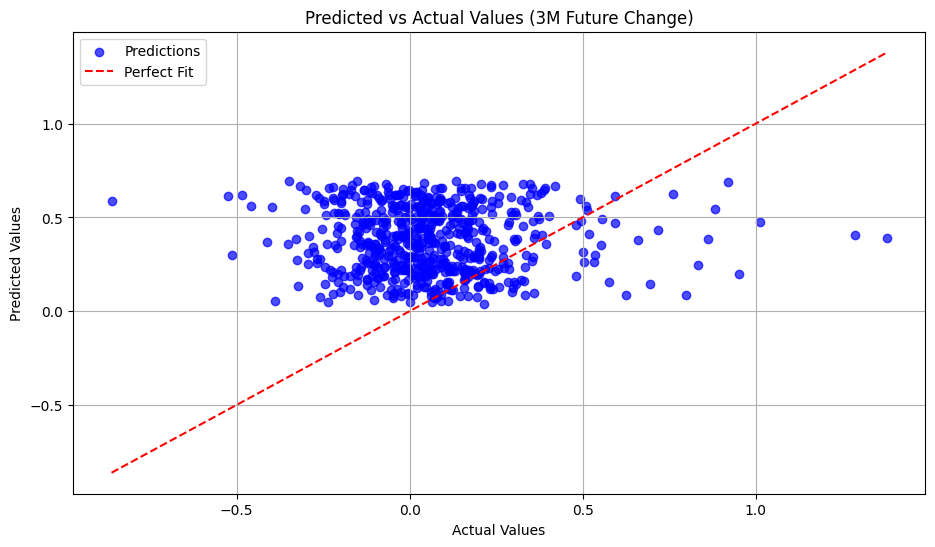

3M Future Change - R²: -2.6361
3M Future Change - MSE: 0.1832
3M Future Change - MAE: 0.3608


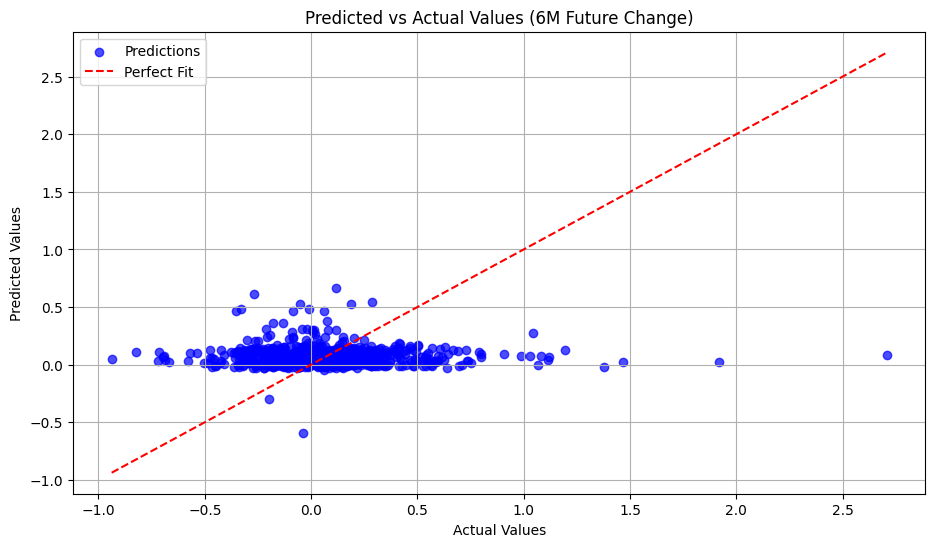

6M Future Change - R²: -0.1049
6M Future Change - MSE: 0.1242
6M Future Change - MAE: 0.2593


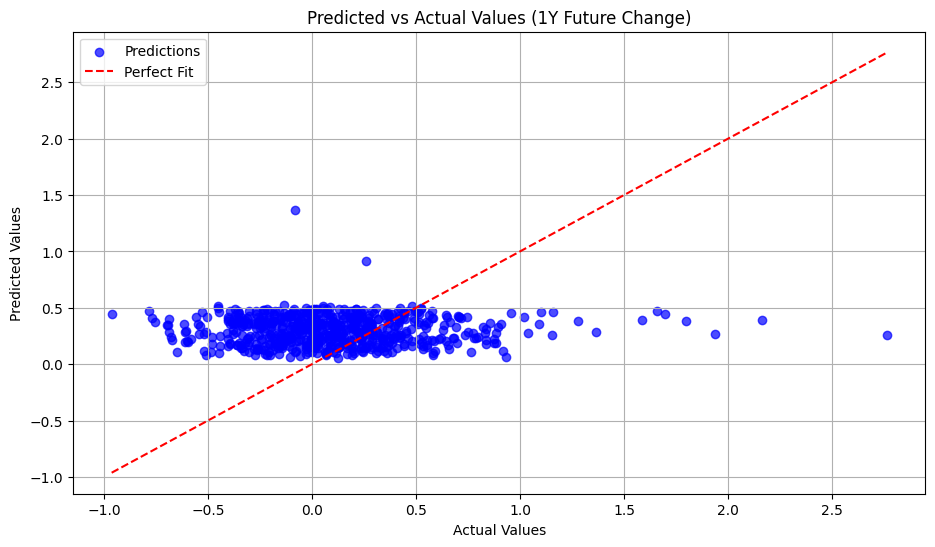

1Y Future Change - R²: -0.3205
1Y Future Change - MSE: 0.2234
1Y Future Change - MAE: 0.3723

Overall Scores:
Mean - R²: -1.0205
Mean - MSE: 0.1769
Mean - MAE: 0.3308


In [12]:
y_test_pred = model.predict(X_test)

for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
    y_test_actual = y_test[target]
    y_test_pred_target = y_test_pred[:, i]

    plt.figure(figsize=(11, 6))
    plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
        color='red', linestyle='--', label='Perfect Fit')
    plt.title(f'Predicted vs Actual Values ({target})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(y_test_actual, y_test_pred_target)
    mse = mean_squared_error(y_test_actual, y_test_pred_target)
    r2 = r2_score(y_test_actual, y_test_pred_target)

    print(f'{target} - R²: {r2:.4f}')
    print(f'{target} - MSE: {mse:.4f}')
    print(f'{target} - MAE: {mae:.4f}')

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('\nOverall Scores:')
print(f'Mean - R²: {r2:.4f}')
print(f'Mean - MSE: {mse:.4f}')
print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [13]:
test_results = pd.DataFrame({
    'R²': r2,
    'MSE': mse,
    'MAE': mae,
    'symbol_list': symbol_list,
    'hidden_layer_sizes': [model.hidden_layer_sizes],
    'max_iter': model.max_iter,
    'n_iter_no_change': model.n_iter_no_change,
    'learning_rate': model.learning_rate,
    'learning_rate_init': model.learning_rate_init,
    'batch_size': model.batch_size,
    'tol': model.tol,
    'alpha': model.alpha,
    'shuffle': model.shuffle,
})
test_results.to_csv('../data/test_results.csv', mode='a', index=False)

## Predictions on latest data